## 1.Count images per class (person)
## 2.Display random sample images
## 3.Check image size variations
## 4.Detect faces in images using MTCNN

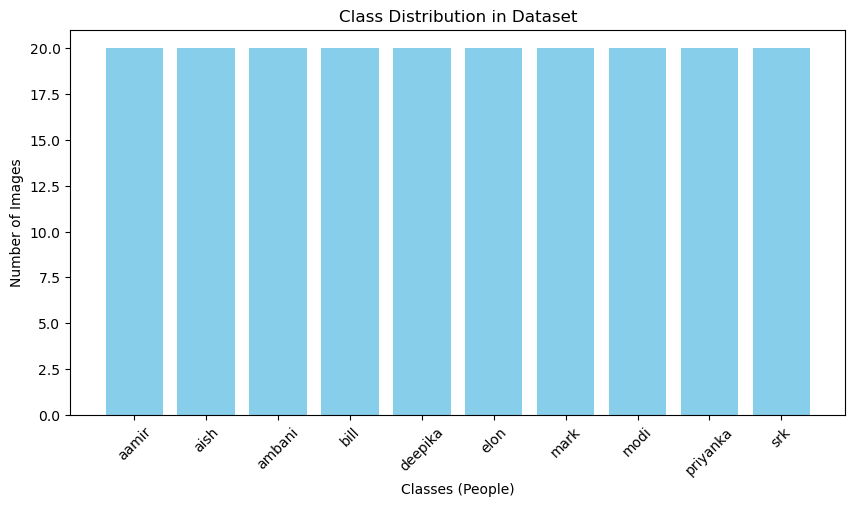

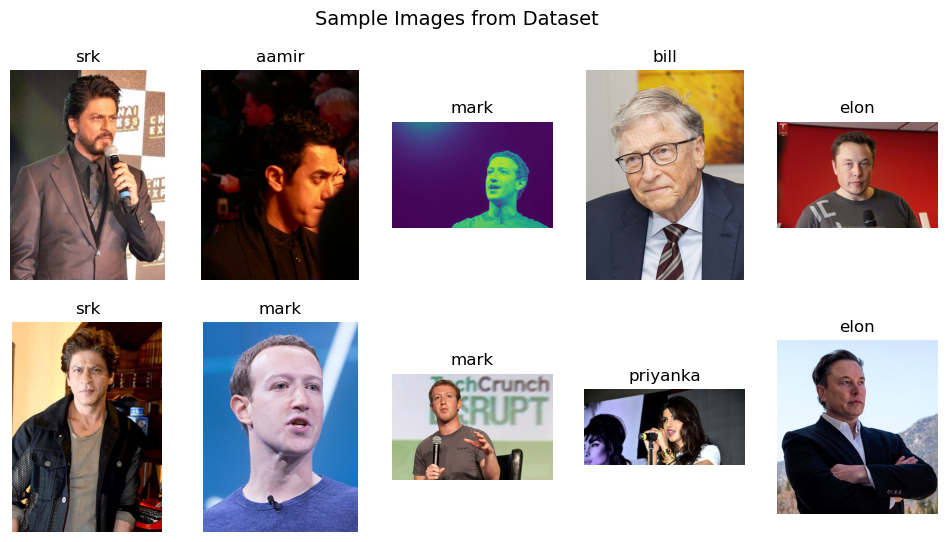

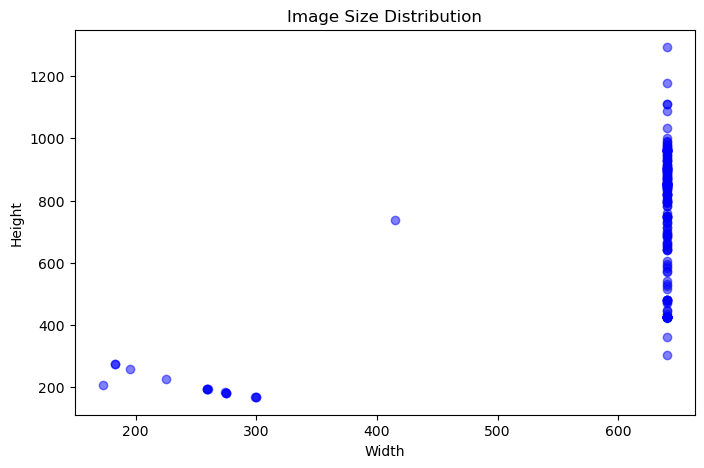

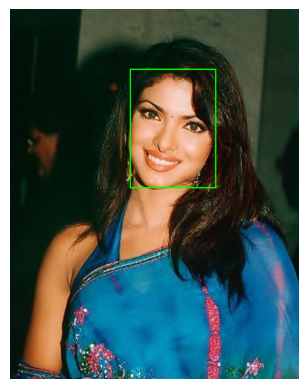

✅ EDA Completed Successfully!


In [3]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from mtcnn import MTCNN

# Define the dataset path
dataset_path = "D:/Dataset"  # Change if needed

# Initialize face detector
detector = MTCNN()

# Store class distribution
class_counts = {}

# Collect dataset info
image_sizes = []
all_images = []

# Iterate through each person's folder
for person in os.listdir(dataset_path):
    person_folder = os.path.join(dataset_path, person)
    
    if os.path.isdir(person_folder):  # Ensure it's a directory
        images = os.listdir(person_folder)
        class_counts[person] = len(images)
        
        for img_name in images:
            img_path = os.path.join(person_folder, img_name)
            
            try:
                img = Image.open(img_path)
                image_sizes.append(img.size)  # Store image dimensions
                all_images.append((img, person))  # Store images for visualization
            except:
                print(f"❌ Could not read {img_path}")

# **1️⃣ Show Class Distribution**
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.xticks(rotation=45)
plt.xlabel("Classes (People)")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Dataset")
plt.show()

# **2️⃣ Show Sample Images**
def show_sample_images():
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle("Sample Images from Dataset", fontsize=14)

    samples = random.sample(all_images, min(10, len(all_images)))
    for i, (img, label) in enumerate(samples):
        ax = axes[i // 5, i % 5]
        ax.imshow(img)
        ax.set_title(label)
        ax.axis("off")
    
    plt.show()

show_sample_images()

# **3️⃣ Check Image Size Variations**
widths, heights = zip(*image_sizes)
plt.figure(figsize=(8, 5))
plt.scatter(widths, heights, alpha=0.5, color="blue")
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Size Distribution")
plt.show()

# **4️⃣ Check Face Detection Using MTCNN**
def detect_faces(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for MTCNN
    detections = detector.detect_faces(img_rgb)

    if detections:
        for det in detections:
            x, y, w, h = det["box"]
            cv2.rectangle(img_rgb, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

# Show face detection on a random image
random_person = random.choice(list(class_counts.keys()))
random_image = random.choice(os.listdir(os.path.join(dataset_path, random_person)))
detect_faces(os.path.join(dataset_path, random_person, random_image))

print("✅ EDA Completed Successfully!")


## 5.Removes duplicates
## 6.Deletes blurry images 
## 7.Adjusts brightness & contrast
## 8.Removes fully occluded faces
## 9.Keeps face angles & tilts (no alignment correction)

In [12]:
import os
import cv2
import numpy as np
import hashlib
import shutil
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from mtcnn import MTCNN

# Path to dataset
dataset_path = "D:/Dataset"  # Update if needed

# Initialize face detector
detector = MTCNN()

# Create a folder for removed images
removed_folder = "Removed_Images/"
if not os.path.exists(removed_folder):
    os.makedirs(removed_folder)


### **🔹 Ensure Unique File Names & Fix Permission Error**
def move_file_unique(src_path, dest_folder):
    """Moves a file to the destination folder with a unique name and ensures it is not locked."""
    filename = os.path.basename(src_path)
    new_path = os.path.join(dest_folder, filename)

    # If file already exists, rename with a number suffix
    count = 1
    while os.path.exists(new_path):
        name, ext = os.path.splitext(filename)
        new_path = os.path.join(dest_folder, f"{name}_{count}{ext}")
        count += 1

    try:
        # Read the file into memory before moving it
        with open(src_path, 'rb') as f:
            temp_data = f.read()

        # Write to new location and then remove old file
        with open(new_path, 'wb') as f:
            f.write(temp_data)

        os.remove(src_path)  # Now delete the original file safely

    except Exception as e:
        print(f"❌ Error moving {src_path}: {e}")


### **1️⃣ Remove Duplicate Images**
def get_file_hash(file_path):
    """Generate a unique hash for each image."""
    hasher = hashlib.md5()
    with open(file_path, 'rb') as f:
        hasher.update(f.read())
    return hasher.hexdigest()

def remove_duplicates():
    hashes = {}
    duplicates = []

    for person in os.listdir(dataset_path):
        person_folder = os.path.join(dataset_path, person)
        if os.path.isdir(person_folder):
            for img_name in os.listdir(person_folder):
                img_path = os.path.join(person_folder, img_name)
                file_hash = get_file_hash(img_path)

                if file_hash in hashes:
                    duplicates.append(img_path)
                    move_file_unique(img_path, removed_folder)  # Move duplicate image safely
                else:
                    hashes[file_hash] = img_path

    print(f"✅ Removed {len(duplicates)} duplicate images.")


### **2️⃣ Remove Blurry Images**
def variance_of_laplacian(image_path):
    """Calculate image sharpness using Laplacian variance."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return cv2.Laplacian(img, cv2.CV_64F).var()

def remove_blurry_images(blur_threshold=100):
    blurry_images = []

    for person in os.listdir(dataset_path):
        person_folder = os.path.join(dataset_path, person)
        for img_name in os.listdir(person_folder):
            img_path = os.path.join(person_folder, img_name)
            if variance_of_laplacian(img_path) < blur_threshold:
                blurry_images.append(img_path)
                move_file_unique(img_path, removed_folder)  # Move blurry image safely

    print(f"✅ Removed {len(blurry_images)} blurry images.")


### **3️⃣ Adjust Brightness & Contrast**
def adjust_brightness_contrast(image_path):
    """Auto-adjust brightness & contrast of an image."""
    img = Image.open(image_path)
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(1.2)  # Increase brightness
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(1.2)  # Increase contrast
    img.save(image_path)  # Save enhanced image

def fix_brightness():
    for person in os.listdir(dataset_path):
        person_folder = os.path.join(dataset_path, person)
        for img_name in os.listdir(person_folder):
            adjust_brightness_contrast(os.path.join(person_folder, img_name))

    print("✅ Brightness & contrast adjusted.")


### **4️⃣ Remove Fully Occluded Faces (But Keep Different Angles)**
def detect_fully_occluded(image_path):
    """Detect if the face is fully occluded or missing."""
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(img_rgb)

    return not bool(faces)  # Returns True if no face is detected

def remove_occluded_faces():
    occluded_images = []

    for person in os.listdir(dataset_path):
        person_folder = os.path.join(dataset_path, person)
        for img_name in os.listdir(person_folder):
            img_path = os.path.join(person_folder, img_name)
            if detect_fully_occluded(img_path):
                occluded_images.append(img_path)
                move_file_unique(img_path, removed_folder)  # Move occluded image safely

    print(f"✅ Removed {len(occluded_images)} fully occluded images.")


### **🔹 Run All Fixes Sequentially**
def clean_dataset():
    print("\n🔹 Starting dataset cleanup...\n")
    remove_duplicates()
    remove_blurry_images()
    fix_brightness()
    remove_occluded_faces()
    print("\n✅ Dataset cleanup completed successfully!")

clean_dataset()



🔹 Starting dataset cleanup...

❌ Error moving D:/Dataset\srk\19S.jpg: [WinError 32] The process cannot access the file because it is being used by another process: 'D:/Dataset\\srk\\19S.jpg'
✅ Removed 1 duplicate images.
❌ Error moving D:/Dataset\aamir\11a.jpg: [WinError 32] The process cannot access the file because it is being used by another process: 'D:/Dataset\\aamir\\11a.jpg'
❌ Error moving D:/Dataset\aamir\13a.jpg: [WinError 32] The process cannot access the file because it is being used by another process: 'D:/Dataset\\aamir\\13a.jpg'
❌ Error moving D:/Dataset\aamir\14a.jpg: [WinError 32] The process cannot access the file because it is being used by another process: 'D:/Dataset\\aamir\\14a.jpg'
❌ Error moving D:/Dataset\aamir\16a.jpg: [WinError 32] The process cannot access the file because it is being used by another process: 'D:/Dataset\\aamir\\16a.jpg'
❌ Error moving D:/Dataset\aamir\3a.jpg: [WinError 32] The process cannot access the file because it is being used by anoth

In [13]:
import os
import cv2
from PIL import Image
from mtcnn import MTCNN

# Path to dataset
dataset_path = "D:/Dataset"  # Update if needed
target_size = (160, 160)  # Recommended size for FaceNet

# Initialize MTCNN face detector
detector = MTCNN()

def detect_and_resize(image_path):
    """Detects face, crops it, and resizes it to 160x160."""
    try:
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for MTCNN
        faces = detector.detect_faces(img_rgb)

        if faces:  # If face is detected
            x, y, w, h = faces[0]["box"]  # Get bounding box
            cropped_face = img_rgb[y:y+h, x:x+w]  # Crop the face region
            face_resized = cv2.resize(cropped_face, target_size)  # Resize face to 160x160

            # Convert back to PIL image and save
            final_img = Image.fromarray(face_resized)
            final_img.save(image_path)  # Overwrite original image

        else:
            print(f"⚠️ No face detected in {image_path}, skipping.")

    except Exception as e:
        print(f"❌ Error processing {image_path}: {e}")

def process_all_images():
    """Loops through dataset, detects faces, and resizes images."""
    for person in os.listdir(dataset_path):
        person_folder = os.path.join(dataset_path, person)
        if os.path.isdir(person_folder):  # Ensure it's a folder
            for img_name in os.listdir(person_folder):
                img_path = os.path.join(person_folder, img_name)
                detect_and_resize(img_path)

    print("✅ All images are cropped and resized to 160×160 successfully!")

process_all_images()


⚠️ No face detected in D:/Dataset\bill\16B.jpg, skipping.
⚠️ No face detected in D:/Dataset\deepika\12D.jpg, skipping.
⚠️ No face detected in D:/Dataset\modi\12N.jpg, skipping.
⚠️ No face detected in D:/Dataset\priyanka\17P.jpg, skipping.
✅ All images are cropped and resized to 160×160 successfully!


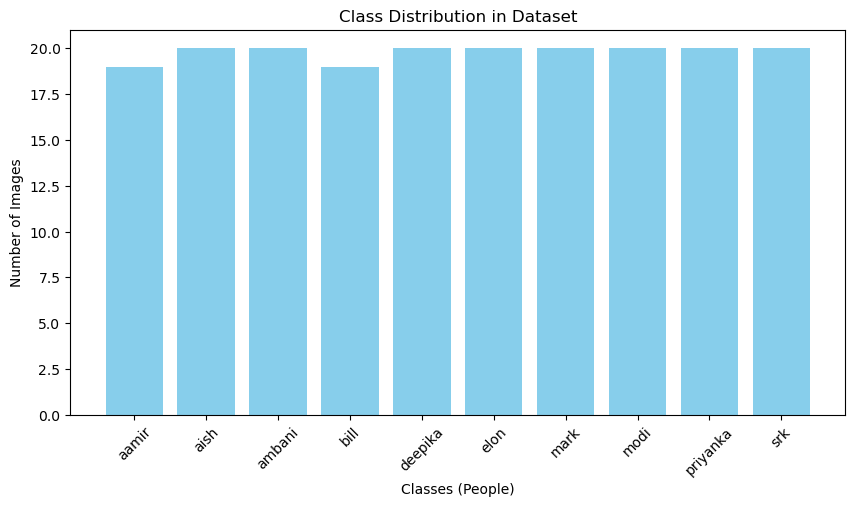

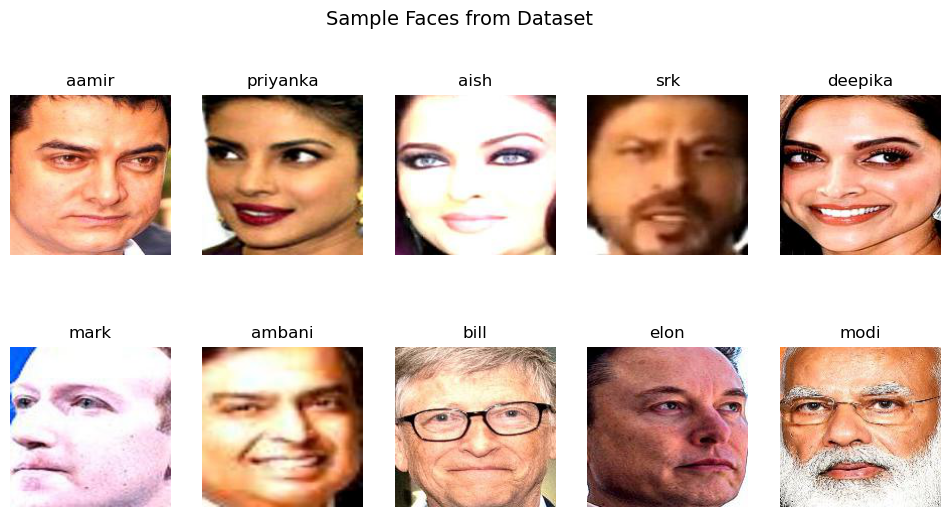

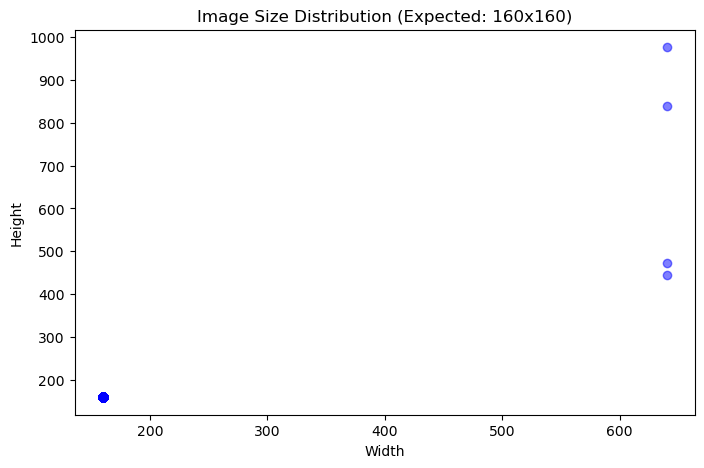

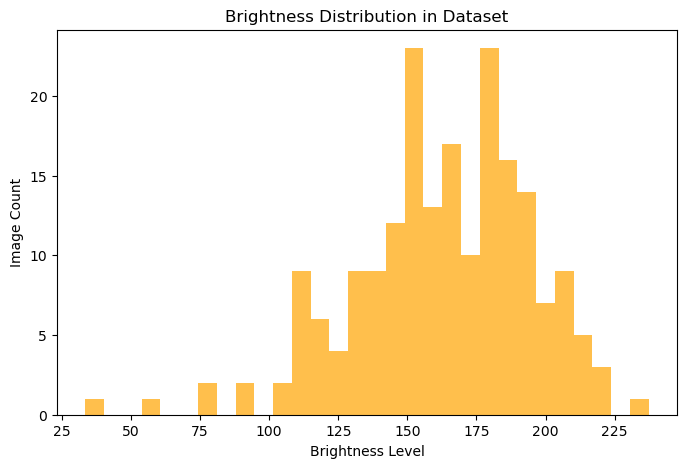

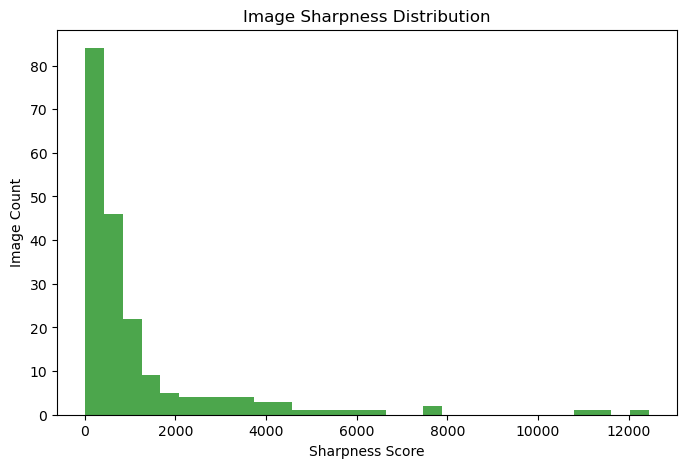

aamir: 19/19 faces detected (100.00%)
aish: 20/20 faces detected (100.00%)
ambani: 20/20 faces detected (100.00%)
bill: 15/19 faces detected (78.95%)
deepika: 19/20 faces detected (95.00%)
elon: 20/20 faces detected (100.00%)
mark: 20/20 faces detected (100.00%)
modi: 19/20 faces detected (95.00%)
priyanka: 17/20 faces detected (85.00%)
srk: 18/20 faces detected (90.00%)

✅ EDA Completed Successfully!


In [16]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from mtcnn import MTCNN

# Path to dataset
dataset_path = "D:/Dataset"  # Update if needed
detector = MTCNN()

# Store class distribution
class_counts = {}
image_sizes = []
brightness_levels = []
sharpness_scores = []
face_detection_results = {}

# **1️⃣ Class Distribution**
for person in os.listdir(dataset_path):
    person_folder = os.path.join(dataset_path, person)
    if os.path.isdir(person_folder):
        images = os.listdir(person_folder)
        class_counts[person] = len(images)

# **2️⃣ Show Sample Faces**
def show_sample_images():
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle("Sample Faces from Dataset", fontsize=14)

    sample_classes = random.sample(list(class_counts.keys()), min(10, len(class_counts)))

    for i, person in enumerate(sample_classes):
        img_name = random.choice(os.listdir(os.path.join(dataset_path, person)))
        img_path = os.path.join(dataset_path, person, img_name)
        img = Image.open(img_path)

        ax = axes[i // 5, i % 5]
        ax.imshow(img)
        ax.set_title(person)
        ax.axis("off")

    plt.show()


# **3️⃣ Image Size Consistency**
for person in os.listdir(dataset_path):
    person_folder = os.path.join(dataset_path, person)
    if os.path.isdir(person_folder):
        for img_name in os.listdir(person_folder):
            img_path = os.path.join(person_folder, img_name)
            img = Image.open(img_path)
            image_sizes.append(img.size)

# **4️⃣ Face Detection Success Rate**
def detect_faces(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detections = detector.detect_faces(img_rgb)
    return len(detections) > 0  # True if a face is detected

for person in os.listdir(dataset_path):
    person_folder = os.path.join(dataset_path, person)
    detected_count = 0
    total_count = 0
    
    if os.path.isdir(person_folder):
        for img_name in os.listdir(person_folder):
            img_path = os.path.join(person_folder, img_name)
            if detect_faces(img_path):
                detected_count += 1
            total_count += 1

    face_detection_results[person] = (detected_count, total_count)

# **5️⃣ Brightness & Contrast Analysis**
def calculate_brightness(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return np.mean(img)  # Average pixel intensity

for person in os.listdir(dataset_path):
    person_folder = os.path.join(dataset_path, person)
    for img_name in os.listdir(person_folder):
        img_path = os.path.join(person_folder, img_name)
        brightness_levels.append(calculate_brightness(img_path))

# **6️⃣ Image Sharpness Distribution**
def variance_of_laplacian(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return cv2.Laplacian(img, cv2.CV_64F).var()

for person in os.listdir(dataset_path):
    person_folder = os.path.join(dataset_path, person)
    for img_name in os.listdir(person_folder):
        img_path = os.path.join(person_folder, img_name)
        sharpness_scores.append(variance_of_laplacian(img_path))

# **7️⃣ Show Plots for Analysis**
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.xticks(rotation=45)
plt.xlabel("Classes (People)")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Dataset")
plt.show()

show_sample_images()

plt.figure(figsize=(8, 5))
widths, heights = zip(*image_sizes)
plt.scatter(widths, heights, alpha=0.5, color="blue")
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Size Distribution (Expected: 160x160)")
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(brightness_levels, bins=30, color="orange", alpha=0.7)
plt.xlabel("Brightness Level")
plt.ylabel("Image Count")
plt.title("Brightness Distribution in Dataset")
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(sharpness_scores, bins=30, color="green", alpha=0.7)
plt.xlabel("Sharpness Score")
plt.ylabel("Image Count")
plt.title("Image Sharpness Distribution")
plt.show()

# Print face detection success rate
for person, (detected, total) in face_detection_results.items():
    print(f"{person}: {detected}/{total} faces detected ({(detected/total)*100:.2f}%)")

print("\n✅ EDA Completed Successfully!")


# Dataset Augmentation

In [3]:
pip install albumentations opencv-python pillow numpy --user


  Using cached albumentations-2.0.5-py3-none-any.whl.metadata (41 kB)
  Using cached pydantic-2.10.6-py3-none-any.whl.metadata (30 kB)
  Using cached albucore-0.0.23-py3-none-any.whl.metadata (5.3 kB)
  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached albumentations-2.0.5-py3-none-any.whl (290 kB)
Using cached albucore-0.0.23-py3-none-any.whl (14 kB)
Using cached opencv_python_headless-4.11.0.86-cp37-abi3-win_amd64.whl (39.4 MB)
Using cached pydantic-2.10.6-py3-none-any.whl (431 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import cv2
import numpy as np
import random
from PIL import Image
import albumentations as A

# Path to dataset
dataset_path = "D:/Dataset"  
augmented_folder = "D:/Augmented_Dataset"  

# Define augmentation transformations
augmentations = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  
    A.Rotate(limit=10, p=0.5),  
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),  # Fixed
    A.MotionBlur(blur_limit=3, p=0.3),  
    A.RandomResizedCrop(size=(160, 160), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.5)  # Fixed
])

# Ensure output folder exists
os.makedirs(augmented_folder, exist_ok=True)

def augment_image(image_path, save_path):
    """Applies augmentations and saves the new image."""
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    augmented = augmentations(image=img_rgb)['image']  
    cv2.imwrite(save_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))  

def augment_dataset():
    """Loops through dataset and applies augmentations."""
    for person in os.listdir(dataset_path):
        person_folder = os.path.join(dataset_path, person)
        augmented_person_folder = os.path.join(augmented_folder, person)
        os.makedirs(augmented_person_folder, exist_ok=True)

        if os.path.isdir(person_folder):
            for img_name in os.listdir(person_folder):
                img_path = os.path.join(person_folder, img_name)

                # Generate 3 augmented versions per image
                for i in range(3):
                    new_img_name = f"{os.path.splitext(img_name)[0]}_aug{i}.jpg"
                    save_path = os.path.join(augmented_person_folder, new_img_name)
                    augment_image(img_path, save_path)

    print("✅ Dataset augmentation completed! New images saved in 'Augmented_Dataset/'")

augment_dataset()


C:\Users\Bhuvan M\AppData\Local\Temp\ipykernel_12840\1744726726.py:16: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),  # Fixed


✅ Dataset augmentation completed! New images saved in 'Augmented_Dataset/'


In [5]:
import os
import shutil

# Define paths
original_dataset = "D:/Dataset"  
augmented_dataset = "D:/Augmented_Dataset"  

def merge_datasets():
    """Moves original images into Augmented_Dataset without duplicates."""
    for person in os.listdir(original_dataset):
        orig_person_folder = os.path.join(original_dataset, person)
        aug_person_folder = os.path.join(augmented_dataset, person)

        os.makedirs(aug_person_folder, exist_ok=True)  # Ensure person folder exists in Augmented_Dataset

        if os.path.isdir(orig_person_folder):
            for img_name in os.listdir(orig_person_folder):
                orig_img_path = os.path.join(orig_person_folder, img_name)
                new_img_path = os.path.join(aug_person_folder, img_name)

                # Move only if the file does not already exist
                if not os.path.exists(new_img_path):
                    shutil.move(orig_img_path, new_img_path)

    print("✅ Merge completed! All images are now in 'Augmented_Dataset/'")

merge_datasets()


✅ Merge completed! All images are now in 'Augmented_Dataset/'
